# Section 02
Exploring Monte Carlo methods: integral evaluations and random walks

In [10]:
import subprocess as proc
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 130})

# Base directory for stored data
root = Path("..")

# Base directory for the random generator seed and primes files
rng_dir = root / "data"
# Directory in which run results are/will be stored
data_dir = root / "results" / "02"


## Exercise 02.1
Estimating
$$
\mathrm{I} = \int_{0}^{1}\frac{\pi}{2}\cos(\frac{\pi}{2}x)
$$
as an expectation value using Monte Carlo. Both uniform and gaussian sampling will be tried and compared. Blocking method is used to give estimates and their statistical uncertainty.

### Gaussian sampling
Gaussian sampling is performed on the interval $[-\infty,\infty]$. The integral is rewritable as:
$$
\mathrm{I} = \int_{0}^{1}\frac{\pi}{2}\cos(\frac{\pi}{2}x) = \int_{-1}^{1}\frac{1}{2}\frac{\pi}{2}\cos(\frac{\pi}{2}x)\sqrt{2\pi}e^{\frac{x^2}{2}}\frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}=\int_{-\infty}^{\infty}f(x)\frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}
$$
hence $\mathrm{I} = \mathbb{E}_{\mathcal{N}(0,1)}[f(x)]$, with
$$
\begin{equation*}
f(x) = \left\{
        \begin{array}{ll}
            \frac{\pi}{4}\cos(\frac{\pi}{2}x)\sqrt{2\pi}e^{\frac{x^2}{2}} & x \in [-1, 1] \\
            0 & x \notin [-1, 1]
        \end{array}
    \right.
\end{equation*}
$$
The interval $[-1, 1]$ and a factor $\frac{1}{2}$ are used instead of $[0, 1]$ as to exploit more sampled points to evaluate the nonzero contributions to $\mathrm{I}$. \
Cosine sampling on $[0,\pi/2]$ with $f(x)=1$ could also be performed, but of course that would lead directly to the correct result with zero variance and no particular insight on the process.

In [11]:
ex = "02_1"

# Whether to run the program or use cached results
USE_CACHED = False

# Path to the executable
executable = root / "bin" / ex
I_file = data_dir / f"{ex}.csv"

# The program is run using the following parameters:
N_BLOCKS = int(1e2)
N_THROWS = int(1e6)
if not (USE_CACHED and I_file.exists()):
    proc.run(
        [
            executable,
            f"--primes_path={rng_dir/'primes'/'Primes'}",
            f"--seeds_path={rng_dir/'seeds'/'seed.in'}",
            f"--primes_line=15",
            f"--n_blocks={N_BLOCKS}",
            f"--n_throws={N_THROWS}",
            f"--out={I_file}",
        ]
    )

# Pandas DataFrames storing the integral estimates
I_data = pd.read_csv(I_file)


(0.997, 1.005)

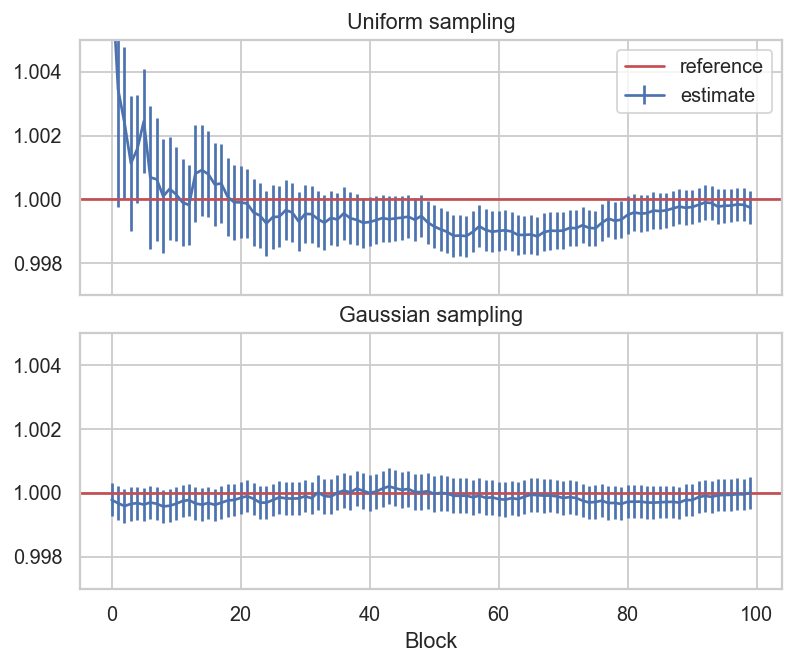

In [12]:
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 5), constrained_layout=True)

# Plotting the uniform sampling results
I_data.plot.line(y="I1_estimate", yerr="I1_error", ax=axes[0], label="estimate")
axes[0].axhline(1.0, c="r", label="reference")
axes[0].set_title("Uniform sampling")
axes[0].set_xlabel("Block")
axes[0].set_ylim(0.997, 1.005)
axes[0].legend()

#Plotting the gaussian sampling results
I_data.plot.line(y="I2_estimate", yerr="I2_error", ax=axes[1], legend=False)
axes[1].axhline(1.0, c="r", label="reference")
axes[1].set_title("Gaussian sampling")
axes[1].set_xlabel("Block")
axes[1].set_ylim(0.997, 1.005)


Both estimations are compatible with the correct result. Gaussian sampling leads to a quicker stabilization of the estimate (and consequently of the statistical uncertainty) as it better exploits the shape of the integrand, hence sampling more points from the most significant regions of integration

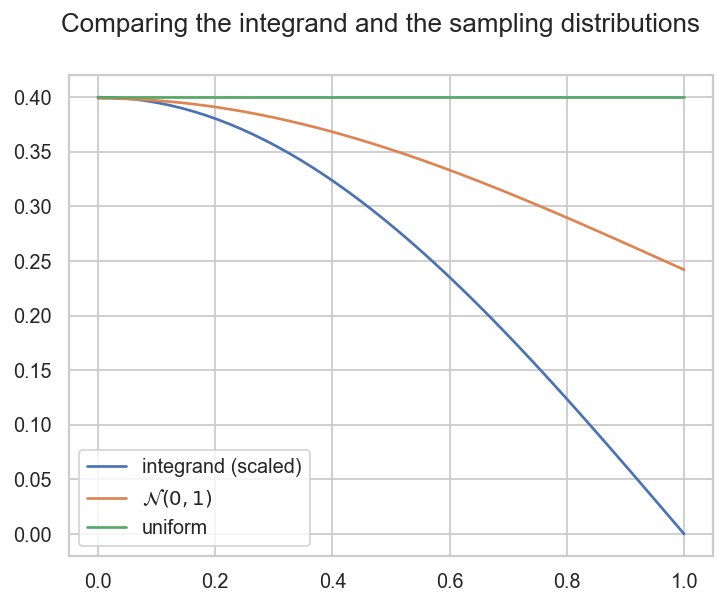

In [13]:
xs = np.linspace(0, 1)
plt.plot(xs, 0.4*np.cos(xs*np.pi/2), label="integrand (scaled)")
plt.plot(xs, stats.norm(0, 1).pdf(xs), label=r"$\mathcal{N}(0, 1)$")
plt.plot(xs, np.full_like(xs, 0.4), label="uniform")
plt.legend()
_ = plt.suptitle("Comparing the integrand and the sampling distributions")

## Exercise 02.2
Estimating the expected distance from the origin reached by a 3D random walk using two different step strategies.
The quantity $\sqrt{\langle |\vec{r}_N|^2 \rangle}$, where $N$ is the walk length, is inspected. $\frac{\delta r^2}{2*\sqrt{\langle |\vec{r}_N|^2 \rangle}}$, where $\delta r^2$ is the statistical uncertainty on the estimation of $\langle |\vec{r}_N|^2 \rangle$, will be used as error. \
The step strategies are:
- uniform axial steps: the direction is sampled uniformly from the three axes (positive or negative);
- uniform direction steps: directions are sampled as points uniformly distributed on a sphere surface.

In [14]:
ex = "02_2"

# Path to the executable
executable = root / "bin" / ex
walk_file = lambda w_l: data_dir / f"{ex}_{w_l}.csv"

# The program is run using the following parameters:
# Total number of blocks in which the simulations are divided
N_BLOCKS = int(1e2)
# Total number of simulations
N_SIMULATIONS = int(1e4)
# Multiple walk lengths are used to inspect the dependency of the distance on the walk length
WALK_LENGTHS = [x**2 for x in range(2, 17, 2)]
for WALK_LENGTH in WALK_LENGTHS:
    if not (USE_CACHED and walk_file(WALK_LENGTH).exists()):
        proc.run(
            [
                executable,
                f"--primes_path={rng_dir/'primes'/'Primes'}",
                f"--seeds_path={rng_dir/'seeds'/'seed.in'}",
                f"--primes_line=1",
                f"--n_blocks={N_BLOCKS}",
                f"--n_simulations={N_SIMULATIONS}",
                f"--walk_length={WALK_LENGTH}",
                f"--out={walk_file(WALK_LENGTH)}",
            ]
        )

# Pandas DataFrames storing the distance estimates
walk_data = [pd.read_csv(walk_file(WALK_LENGTH)) for WALK_LENGTH in WALK_LENGTHS]

# Extracting the final estimates 
data_points = pd.concat(
    [
        w_d.iloc[[-1]].rename(index=lambda _: w_l)
        for w_d, w_l in zip(walk_data, WALK_LENGTHS)
    ],
    axis="index",
).rename_axis(index="walk_length")


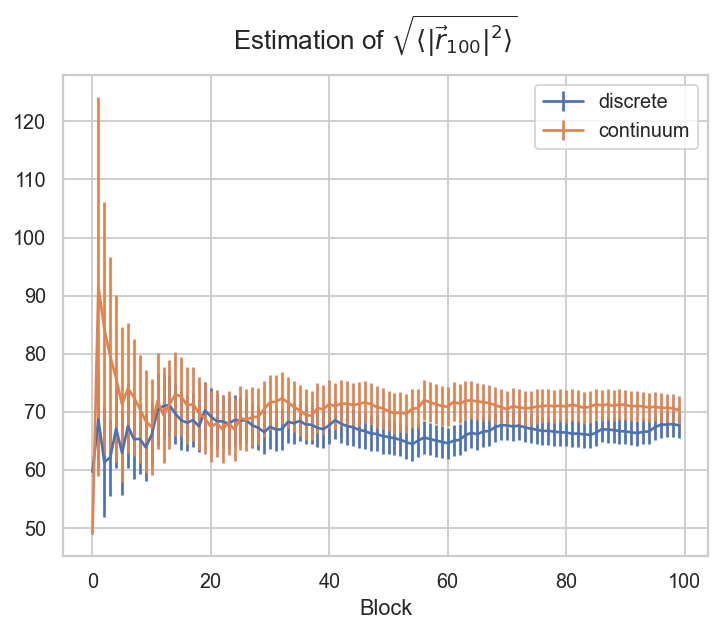

In [15]:
# Plotting the estimation for walk_length = 100
ax = walk_data[4].plot.line(y="discrete_mean", yerr="discrete_error", label="discrete")
walk_data[4].plot.line(y="continuum_mean", yerr="continuum_error", ax=ax, label="continuum")
ax.figure.suptitle(r"Estimation of $\sqrt{\langle |\vec{r}_{100}|^2 \rangle}$")
ax.set_xlabel("Block")
_ = ax.legend()

The plot above shows the estimation of distance from the origin using a walk length of 100. Both walk strategies lead to essantialy the same result.

In [16]:
# Showing the raw results
data_points


,discrete_mean,discrete_error,continuum_mean,continuum_error
walk_length,,,,
4,11.7367,0.382740,12.7988,0.405107
16,27.2463,0.858274,25.8622,0.928493
36,43.3170,1.226930,42.6218,1.494120
64,55.9028,1.796390,56.3808,1.782070
100,67.6450,2.175520,70.2889,2.438210
144,86.3743,2.908170,87.6665,3.255830
196,95.1946,2.958370,101.2290,3.172820
256,115.4480,4.051010,117.8030,4.243460


In [17]:
from scipy.optimize import curve_fit

best_param_discr, cov_discr = curve_fit(
    lambda N, k: k * np.sqrt(N),
    data_points.index,
    data_points["discrete_mean"],
    sigma=data_points["discrete_error"],
)
print(f"Fitting the axial walker with k*√N: k = {best_param_discr[0]:.2f} +- {cov_discr[0,0]:.2f}")
best_param_cont, cov_cont = curve_fit(
    lambda N, k: k * np.sqrt(N),
    data_points.index,
    data_points["continuum_mean"],
    sigma=data_points["continuum_error"],
)
print(f"Fitting the uniform walker with k*√N: k = {best_param_cont[0]:.3f} +- {cov_cont[0,0]:.3f}")


Fitting the axial walker with k*√N: k = 6.81 +- 0.03
Fitting the uniform walker with k*√N: k = 6.947 +- 0.018


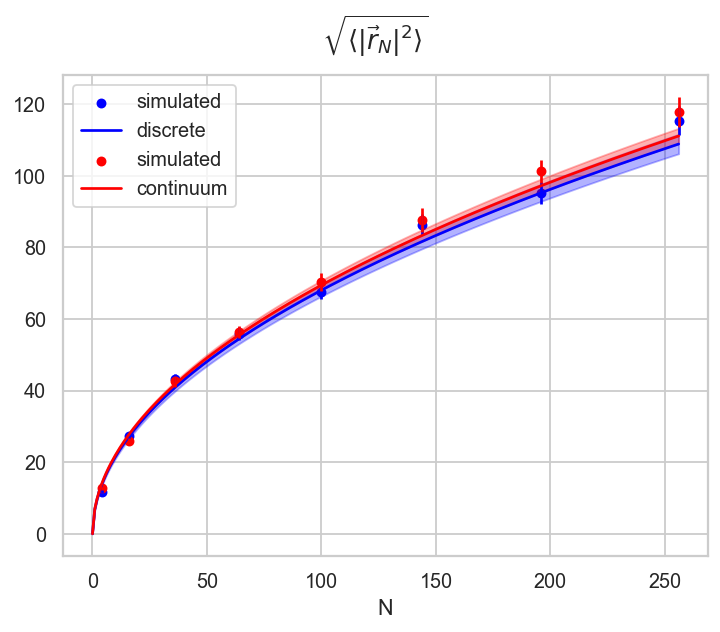

In [18]:
# Plotting the variable against the walk length, with transform fit
ax = data_points.reset_index(drop=False).plot.scatter(
    x="walk_length", y="discrete_mean", yerr="discrete_error", color="blue", label="simulated"
)
Ns = np.arange(0, 257, dtype="int")
ax.plot(Ns, best_param_discr * np.sqrt(Ns), label="discrete", color="blue")
ax.fill_between(
    Ns,
    (best_param_discr- np.sqrt(cov_discr[0, 0])) * np.sqrt(Ns) ,
    (best_param_discr + np.sqrt(cov_discr[0, 0])) * np.sqrt(Ns),
    color="blue",
    alpha=.3
)
data_points.reset_index(drop=False).plot.scatter(
    x="walk_length", y="continuum_mean", yerr="continuum_error", color="red", ax=ax, label="simulated"
)
ax.plot(Ns, best_param_cont * np.sqrt(Ns), label="continuum", color="red")
ax.fill_between(
    Ns,
    (best_param_cont- np.sqrt(cov_cont[0, 0])) * np.sqrt(Ns) ,
    (best_param_cont + np.sqrt(cov_cont[0, 0])) * np.sqrt(Ns),
    color="red",
    alpha=.3
)
ax.legend()
ax.set_xlabel("N")
ax.set_ylabel(None)
_ = ax.figure.suptitle(r"$\sqrt{\langle |\vec{r}_{N}|^2 \rangle}$")


The plot above shows that both step strategies behave the same way, and with good approximation $\sqrt{\langle |\vec{r}_{N}|^2 \rangle}$ can be modeled by $k \cdot \sqrt{N}$